# Importando as bibliotecas:

In [ ]:
pip install onnxruntime

In [ ]:
pip install onnx

In [ ]:
pip install tensorflow

In [ ]:
pip install onnx-tf

In [ ]:
import onnxruntime
import tensorflow as tf
from google.colab import drive
import onnx
from onnx_tf.backend import prepare
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# Carregando o modelo onnx:

In [ ]:
# Conectando ao Google Drive:
drive.mount('/content/drive')

# Caminho do arquivo do seu modelo ONNX:
modelo_onnx = '/content/drive/MyDrive/yolo_pesos/best.onnx'

# Carregando o modelo em estado de inferência:
model_run = onnxruntime.InferenceSession(modelo_onnx)

# Carregando o modelo em si:
model = onnx.load(modelo_onnx)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Obtendo informações sobre os nós de entrada
input_info = model_run.get_inputs()

# Iterando sobre os nós de entrada para encontrar as dimensões de entrada
for input_node in input_info:
    input_name = input_node.name
    input_shape = input_node.shape

    input_type = input_node.type
    print(f"Entrada: {input_name}, Formato: {input_shape}, Tipo: {input_type}")

# Obtendo informações sobre os nós de saída
output_info = model_run.get_outputs()

# Iterando sobre os nós de saída para encontrar as dimensões de saída
for output_node in output_info:
    output_name = output_node.name
    output_shape = output_node.shape
    output_type = output_node.type
    print(f"Saída: {output_name}, Formato: {output_shape}, Tipo: {output_type}")

Entrada: images, Formato: [1, 3, 320, 320], Tipo: tensor(float)
Saída: output, Formato: ['Concatoutput_dim_0', 7], Tipo: tensor(float)


# Realizando uma inferência no modelo:

In [ ]:
# Carregar a imagem
image_to_show = cv2.imread('/content/drive/MyDrive/yolo_pesos/amostras/amostra7.jpg')

# Converter de BGR para RGB (OpenCV carrega imagens como BGR por padrão)
image_to_show = cv2.cvtColor(image_to_show, cv2.COLOR_BGR2RGB)

# Redimensionar a imagem para as dimensões esperadas pelo modelo
image_to_show = cv2.resize(image_to_show, (320, 320))

# Converter para ponto flutuante e normalizar
image_norm = image_to_show.astype(np.float32) / 255.0

# Transpor as dimensões para corresponder à forma esperada pelo modelo
image_norm = image_norm.transpose(2, 0, 1)

# Adicionar uma dimensão extra para corresponder à forma esperada pelo modelo
image_norm = np.expand_dims(image_norm, axis=0)

# Inference (inferência)
output = model_run.run(None, {'images': image_norm})  # Substitua 'input' pelo nome do seu nó de entrada

# Capturando a saída
output_numbers = output[0]

# Verificando as informações da saída:
print(type(output_numbers))
print(output_numbers)

<class 'numpy.ndarray'>
[[  0.         101.96257     70.243355   216.25148    222.75949
    0.           0.83738565]
 [  0.          69.43942    169.18372    135.31157    239.17288
    0.           0.50700456]]


Detecção com o modelo ONNX:


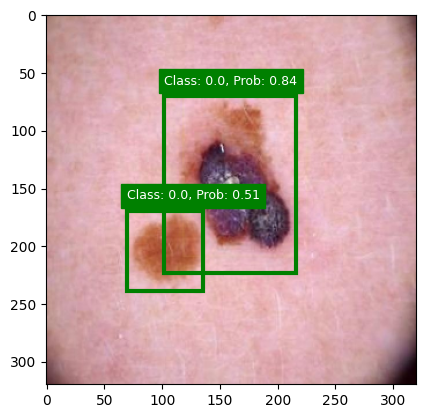

In [ ]:
print("Detecção com o modelo ONNX:")

# Exibindo a imagem
plt.imshow(image_to_show)

for detection in output_numbers:
  # Extraindo informações da detecção
  _, x1, y1, x2, y2, classe, probabilidade = detection  # Supondo que estamos interessados apenas na primeira detecção

  # Calculando largura e altura da bounding box
  bbox_width = x2 - x1
  bbox_height = y2 - y1

  # Adicionando a caixa delimitadora à imagem
  rect = patches.Rectangle((x1, y1), bbox_width, bbox_height, linewidth=3, edgecolor='g', facecolor='none')
  plt.gca().add_patch(rect)

  # Adicionando o texto com a classe e a probabilidade
  plt.text(x1, y1 - 10, f'Class: {classe}, Prob: {probabilidade:.2f}', fontsize=9, color='white', backgroundcolor='green')

# Exibindo a imagem com a bounding box
plt.show()

# Realizando a conversão do modelo ONNX para tf(pb):

In [ ]:
tf_rep = prepare(model)

In [ ]:
tf_model_path = '/content/drive/MyDrive/yolo_pesos/tf_model'

# Salvar o modelo TensorFlow em disco
tf_rep.export_graph(tf_model_path)

Instructions for updating:
Use `tf.image.resize(...method=ResizeMethod.NEAREST_NEIGHBOR...)` instead.
INFO:absl:Function `__call__` contains input name(s) x, y, resource with unsupported characters which will be renamed to transpose_293_x, add_88_y, readvariableop_resource in the SavedModel.
INFO:absl:Found untraced functions such as gen_tensor_dict while saving (showing 1 of 1). These functions will not be directly callable after loading.
INFO:absl:Writing fingerprint to /content/drive/MyDrive/yolo_pesos/tf_model/fingerprint.pb


# Realizando a conversão de modelos tf(pb) para tflite:

In [ ]:
# Convertendo o modelo:
converter_f32 = tf.lite.TFLiteConverter.from_saved_model(tf_model_path)
converter_f16 = tf.lite.TFLiteConverter.from_saved_model(tf_model_path)
converter_int8 = tf.lite.TFLiteConverter.from_saved_model(tf_model_path)

# Definindo as otimizações para float32:
tflite_model_f32 = converter_f32.convert()

# Definindo as otimizações para float16:
converter_f16.optimizations = [tf.lite.Optimize.DEFAULT]
converter_f16.target_spec.supported_ops = [tf.float16]
tflite_model_f16 = converter_f16.convert()

# Definindo as otimizações para int8:
converter_int8.optimizations = [tf.lite.Optimize.DEFAULT]
converter_int8.target_spec.supported_ops = [tf.lite.OpsSet.EXPERIMENTAL_TFLITE_BUILTINS_ACTIVATIONS_INT16_WEIGHTS_INT8]
tflite_model_int8 = converter_int8.convert()

# Realizando o teste em uma imagem com um dos modelos tflite:

In [ ]:
# Carregar a imagem
image_test_2 = cv2.imread('/content/drive/MyDrive/yolo_pesos/amostras/amostra4.jpg')

# Converter de BGR para RGB (OpenCV carrega imagens como BGR por padrão)
image_test_2 = cv2.cvtColor(image_test_2, cv2.COLOR_BGR2RGB)

# Redimensionar a imagem para as dimensões esperadas pelo modelo
image_test_2 = cv2.resize(image_test_2, (320, 320))

# Converter para ponto flutuante e normalizar
image_norm_2 = image_test_2.astype(np.float32) / 255.0

# Transpor as dimensões para corresponder à forma esperada pelo modelo
image_norm_2 = image_norm_2.transpose(2, 0, 1)

# Adicionar uma dimensão extra para corresponder à forma esperada pelo modelo
image_norm_2 = np.expand_dims(image_norm_2, axis=0)

# Carregar o modelo TFLite
interpreter = tf.lite.Interpreter(model_content=tflite_model_f16)
interpreter.allocate_tensors()

# Obter os detalhes dos tensores de entrada e saída
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Definir os dados de entrada do modelo
interpreter.set_tensor(input_details[0]['index'], image_norm_2)

# Realizar a inferência
interpreter.invoke()

# Obter os resultados da inferência
output_data = interpreter.get_tensor(output_details[0]['index'])

print(type(output_data))
print(output_data.shape)

<class 'numpy.ndarray'>
(100, 7)


In [ ]:
# Filtrar as linhas onde a probabilidade é maior que 0.5:
filtered_output_data = [detection for detection in output_data if detection[6] > 0.5]

# Imprimir as linhas filtradas
print(type(filtered_output_data))
print(filtered_output_data)

<class 'list'>
[array([  0.       , 103.050385 ,  51.026566 , 218.81021  , 165.00082  ,
         1.       ,   0.5989851], dtype=float32), array([  0.        , 144.02707   , 225.9794    , 209.48349   ,
       285.71246   ,   1.        ,   0.52433246], dtype=float32)]


Detecção com o modelo tensorflow lite de quantização float16:


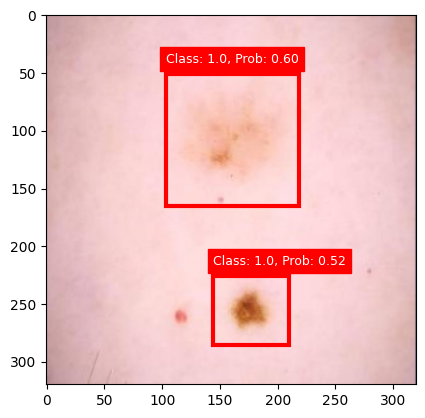

In [ ]:
print("Detecção com o modelo tensorflow lite de quantização float16:")

# Exibindo a imagem
plt.imshow(image_test_2)

for detection in filtered_output_data:
  if (detection[6] >= 0.5):
    # Obter os valores das coordenadas da bounding box
    _, x1, y1, x2, y2, classe, probabilidade = detection

    # Obter as dimensões da imagem
    image_height, image_width, _ = image_test_2.shape

    # Calcular as dimensões da bounding box
    bbox_width = x2 - x1
    bbox_height = y2 - y1

    # Adicionando a caixa delimitadora à imagem
    rect = patches.Rectangle((x1, y1), bbox_width, bbox_height, linewidth=3, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)

    # Adicionando o texto com a classe e a probabilidade
    plt.text(x1, y1 - 10, f'Class: {classe}, Prob: {probabilidade:.2f}', fontsize=9, color='white', backgroundcolor='red')

# Exibindo a imagem com a bounding box
plt.show()

# Salvando os modelos tflite:

In [ ]:
tflite_model_paths = {
    'float32': '/content/drive/MyDrive/yolo_pesos/tf_lite_model_f32.tflite',
    'float16': '/content/drive/MyDrive/yolo_pesos/tf_lite_model_f16.tflite',
    'int8': '/content/drive/MyDrive/yolo_pesos/tf_lite_model_int8.tflite'
}

# Supondo que você tenha os modelos em tflite_models com as chaves 'float32', 'float16' e 'int8'
tflite_models = {
    'float32': tflite_model_f32,
    'float16': tflite_model_f16,
    'int8': tflite_model_int8
}

# Loop para salvar cada modelo
for precision, model in tflite_models.items():
    with open(tflite_model_paths[precision], 'wb') as f:
        f.write(model)